In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")
# root = "D:/Project/customer-churn"
# root = "/root/code_Bao/multiple_time_series_multitask_learning"
# os.chdir(root)

I've noticed that many of you are interested in working with multiple timeseries data and using PyTorch Forecasting. However, it seems that some of you might be encountering difficulties when dealing with multitarget problems (regression/classification) in this context. The existing tutorials on PyTorch forecasting may not cover this specific scenario, as they typically focus on two regression outputs and don't address multi-target forecasting with models like the Temporal Fusion Transformer. </br>
To address this issue, I'm here to offer a comprehensive solution based on the example provided in the PyTorch forecasting documentation, which you can find example [here](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html)

Also check my GitHub link here: https://github.com/mrzaizai2k/multiple_time_series_multitask_learning

In [3]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.7 MB/s eta 0:00:00


In [4]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss,CrossEntropy, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Prepare data

The dataset is all the same as in the original tutorial </br>
Read the Parquet file into a pandas DataFrame

In [5]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

In [6]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,32769,96761,0,0,1,0,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,1219986,218902,0,0,1,0,0,0,0,0,0,0,0,0,5.792496,9
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,135561,100461,0,0,1,0,0,0,0,0,0,0,0,0,7.940950,14
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,3044268,182944,0,0,1,0,0,0,0,0,0,0,0,0,8.981168,22


add time index

In [7]:
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

add additional features

In [8]:
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

we want to encode special days as one variable and thus need to first reverse one-hot encoding

In [9]:
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,53598,95032,-,-,new_year,-,-,-,-,-,-,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,28329,93614,-,-,new_year,-,-,-,-,-,-,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,32183,128574,-,-,-,-,-,independence_day,-,-,-,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,1729177,111048,-,-,-,-,-,-,-,-,-,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,147910,123013,-,-,-,-,-,-,-,-,-,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,3044268,182944,-,-,-,-,-,-,-,-,-,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,135561,100461,-,-,-,-,-,-,-,-,-,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,1739969,210213,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,1868030,175785,-,-,-,-,-,-,-,-,-,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,26635,130092,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


Check levels and missing values. This datset is quite easy as they don't have unequal time length. But I can help you with that situation in the next part

In [10]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]

In [11]:
summarize_categoricals(data[['agency','sku','easter_day','timeseries','month']], show_levels=True)

,Levels,No. of Levels,No. of Missing Values
agency,"['Agency_22', 'Agency_37', 'Agency_59', 'Agenc...",58,0
sku,"['SKU_01', 'SKU_04', 'SKU_03', 'SKU_05', 'SKU_...",25,0
easter_day,"['-', 'easter_day'] Categories (2, object): ['...",2,0
timeseries,"[0, 5, 9, 14, 22, 32, 23, 37, 44, 18, 50, 58, ...",350,0
month,"['1', '2', '3', '4', '5', ..., '8', '9', '10',...",12,0


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
volume,21000.0,1.492404e+03,2.711497e+03,0.000000e+00,8.272388e+00,1.584360e+02,1.774793e+03,2.252661e+04
industry_volume,21000.0,5.439214e+08,6.288022e+07,4.130518e+08,5.090553e+08,5.512000e+08,5.893715e+08,6.700157e+08
soda_volume,21000.0,8.512000e+08,7.824340e+07,6.964015e+08,7.890880e+08,8.649196e+08,9.005551e+08,1.049869e+09
avg_max_temp,21000.0,2.861240e+01,3.972833e+00,1.673103e+01,2.537482e+01,2.847927e+01,3.156840e+01,4.529048e+01
price_regular,21000.0,1.451536e+03,6.833624e+02,0.000000e+00,1.311547e+03,1.495175e+03,1.725652e+03,1.916662e+04
price_actual,21000.0,1.267347e+03,5.877573e+02,-3.121690e+03,1.178366e+03,1.324696e+03,1.517311e+03,4.925404e+03
discount,21000.0,1.843741e+02,2.574700e+02,0.000000e+00,5.493511e+01,1.383072e+02,2.722986e+02,1.916662e+04
avg_population_2017,21000.0,1.045065e+06,9.291926e+05,1.227100e+04,6.018900e+04,1.232242e+06,1.729177e+06,3.137874e+06
avg_yearly_household_income_2017,21000.0,1.510735e+05,5.040959e+04,9.024000e+04,1.100570e+05,1.314110e+05,2.065530e+05,2.472200e+05
discount_in_percent,21000.0,1.057488e+01,9.590813e+00,0.000000e+00,3.749628e+00,8.948990e+00,1.564706e+01,2.267401e+02


In [13]:
filter_data = data[(data['agency']=='Agency_57') & (data['sku']=='SKU_03')].sort_values(by='time_idx')
filter_data.head() # Luôn đủ time idx cho agency và SKU không có mising values

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
232,Agency_57,SKU_03,782.12700,2013-01-01,492612703,718394219,22.219737,1268.558431,1165.031186,103.527245,2212416,187351,-,-,new_year,-,-,-,-,-,-,-,-,-,8.161015,37,0,1,6.662017,1225.306376,1821.292500
7284,Agency_57,SKU_03,801.58500,2013-02-01,431937346,753938444,25.637500,1267.149338,1158.123783,109.025555,2212416,187351,-,-,-,-,-,-,-,-,-,-,-,-,8.604002,37,1,2,6.686591,1289.885997,1963.349531
8968,Agency_57,SKU_03,866.98050,2013-03-01,509281531,892192092,24.925652,1285.234686,1177.612551,107.622135,2212416,187351,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,8.373734,37,2,3,6.765016,1432.225016,2162.780156
10811,Agency_57,SKU_03,1307.40825,2013-04-01,532390389,838099501,27.930736,1312.239461,1129.051331,183.188130,2212416,187351,-,-,-,-,-,-,-,-,-,-,-,-,13.959962,37,3,4,7.175802,1564.910937,2433.855281
12540,Agency_57,SKU_03,1020.44550,2013-05-01,551755254,864420003,27.555022,1318.155168,1122.874614,195.280554,2212416,187351,-,-,-,-,labor_day,-,-,-,-,-,-,-,14.814686,37,4,5,6.927995,1741.896147,2385.850219


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

In [15]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,-,-,new_year,-,-,-,-,-,-,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,32769,96761,-,-,new_year,-,-,-,-,-,-,-,-,-,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,1219986,218902,-,-,new_year,-,-,-,-,-,-,-,-,-,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,135561,100461,-,-,new_year,-,-,-,-,-,-,-,-,-,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,3044268,182944,-,-,new_year,-,-,-,-,-,-,-,-,-,8.981168,22,0,1,6.042417,1179.728165,1638.463500


In [16]:
cate_cols = ['new_year','month']
for col in cate_cols:
    haha = NaNLabelEncoder(add_nan=True).fit_transform(data[col]) #How to use NaNLabelEncoder as it's very important
    print (f"col {col} >>> {set(np.array(haha))}" )

col new_year >>> {1, 2}
col month >>> {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [17]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

# Create Dataset

Here I just use 3 outputs num/cat/num as an example. Pls don't ask for its rationality

In [18]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=["volume","month","industry_volume"], # 3 outputs num/cat/num 
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        # "industry_volume", #remember to remove the targets from others args
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=MultiNormalizer(
        [EncoderNormalizer(method='standard',center=True,max_length=None,transformation=None,method_kwargs={}), 
         NaNLabelEncoder(add_nan=True, warn=True), # Use the NaNLabelEncoder to encode categorical target
         EncoderNormalizer(method='standard',center=True,max_length=None,transformation=None,method_kwargs={}),
         ]
    ),  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [19]:
x, y = next(iter(training.to_dataloader(batch_size=4)))
y[0]

[tensor([[4.2840e+01, 3.8951e+01, 1.9763e+00, 0.0000e+00, 1.8723e+01, 1.2780e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [6.5586e+03, 6.4223e+03, 6.2519e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [8.7922e+03, 1.1086e+04, 1.2707e+04, 1.6759e+04, 1.3016e+04, 1.5310e+04]]),
 tensor([[ 1,  5,  6,  7,  8,  9],
         [ 8,  9, 10, 11, 12,  2],
         [ 7,  8,  9,  0,  0,  0],
         [ 1,  5,  6,  7,  8,  9]]),
 tensor([[5.6215e+08, 5.3025e+08, 6.1314e+08, 5.8997e+08, 6.2876e+08, 6.3685e+08],
         [5.7229e+08, 5.4997e+08, 5.7393e+08, 5.7373e+08, 5.5398e+08, 5.4420e+08],
         [5.8997e+08, 6.2876e+08, 6.3685e+08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.8136e+08, 4.2553e+08, 5.5717e+08, 5.1435e+08, 5.7469e+08, 5.5384e+08]])]

In [20]:
training.target_normalizers

[EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation=None,
 	method_kwargs={}
 ),
 NaNLabelEncoder(add_nan=True, warn=True),
 EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation=None,
 	method_kwargs={}
 )]

In [21]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## configure network and trainer

In [22]:
random_seed = 42

Please check the output_size
- Num target: Here I use Quantiles loss with default 7 
- Cat target: The output_size = num_class + 1 (month has 12 classes >> 13)
- I used Quantile loss for num, and CrossEntropy for Cat

In [23]:
# configure network and trainer
pl.seed_everything(random_seed)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[7,13,7],  # 7 quantiles by default, 3 outputs for Multi-Target. Classification = num_classes + 1
    loss=MultiLoss([QuantileLoss(),CrossEntropy(),QuantileLoss()]), # using MultiLoss for Multi-Target regression/classification
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Global seed set to 42


Number of parameters in network: 30.1k


In [24]:
tft.hparams

"attention_head_size":               1
"categorical_groups":                {'special_days': ['easter_day', 'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day', 'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup', 'football_gold_cup', 'beer_capital', 'music_fest']}
"causal_attention":                  True
"dropout":                           0.1
"embedding_labels":                  {'agency': {'Agency_01': 0, 'Agency_02': 1, 'Agency_03': 2, 'Agency_04': 3, 'Agency_05': 4, 'Agency_07': 5, 'Agency_08': 6, 'Agency_09': 7, 'Agency_10': 8, 'Agency_11': 9, 'Agency_12': 10, 'Agency_13': 11, 'Agency_15': 12, 'Agency_16': 13, 'Agency_17': 14, 'Agency_18': 15, 'Agency_19': 16, 'Agency_20': 17, 'Agency_21': 18, 'Agency_22': 19, 'Agency_23': 20, 'Agency_24': 21, 'Agency_25': 22, 'Agency_26': 23, 'Agency_27': 24, 'Agency_28': 25, 'Agency_29': 26, 'Agency_30': 27, 'Agency_31': 28, 'Agency_32': 29, 'Agency_33': 30, 'Agency_34': 31, 'Agency_35': 32, 'Agency_36': 33,

find optimal learning rate

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 0.07943282347242808


suggested learning rate: 0.07943282347242808


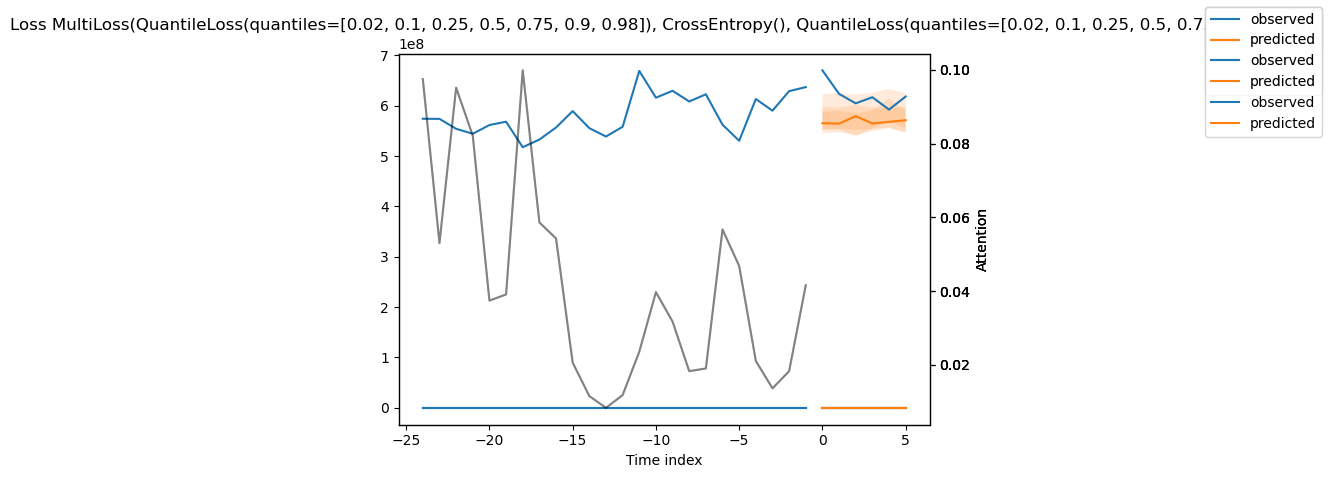

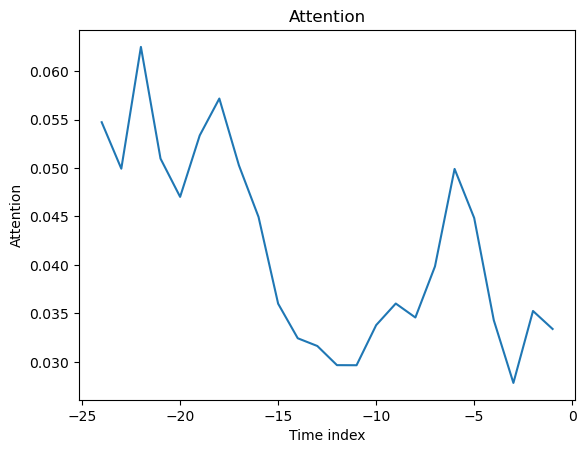

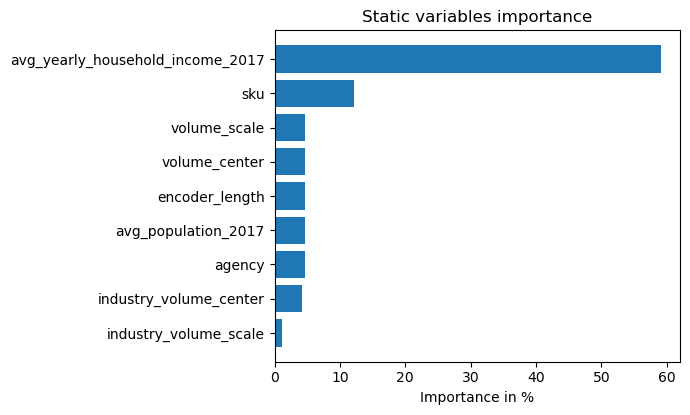

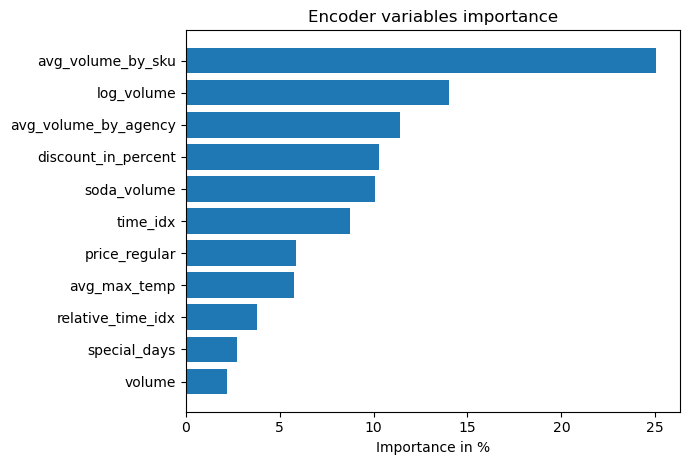

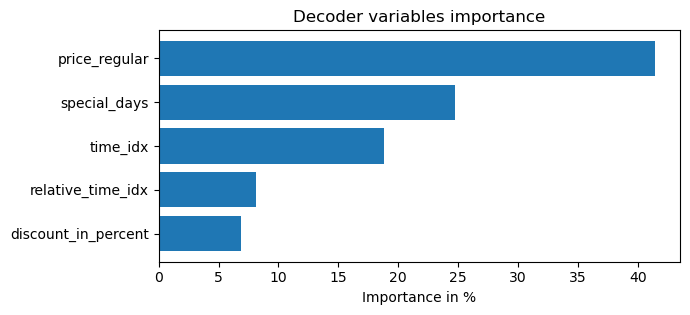

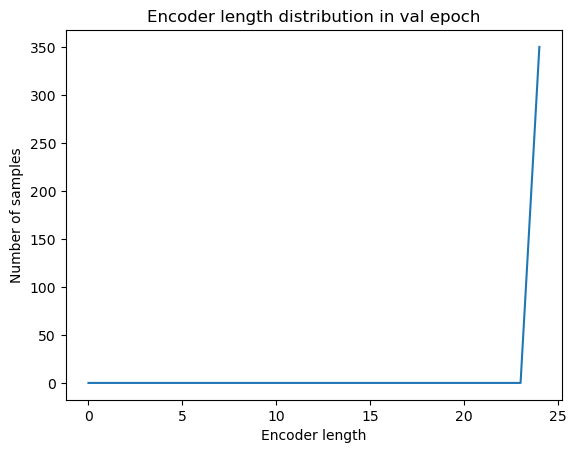

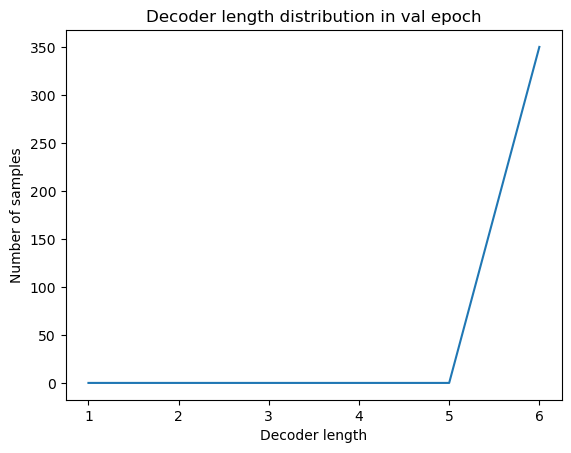

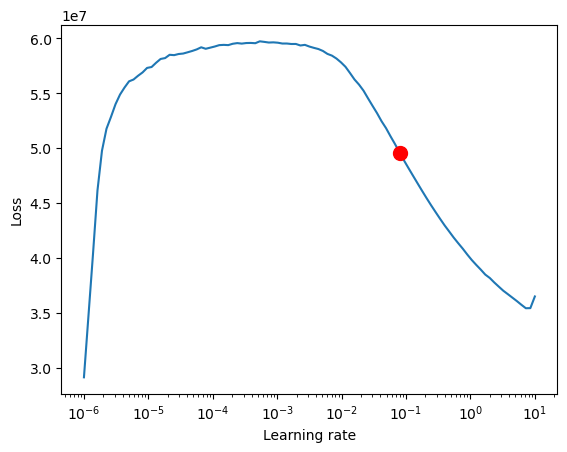

In [25]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Training

In [26]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=2,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

In [27]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=[7,13,7],  # 7 quantiles by default, 3 outputs for Multi-Target. Classification = num_classes + 1
    loss=MultiLoss([QuantileLoss(),CrossEntropy(),QuantileLoss()]), # using MultiLoss for Multi-Target regression/classification
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 30.1k


In [28]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.2 K 
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

This is to load the model you want

In [29]:
# best_model_path = 'lightning_logs_test/lightning_logs/version_0/checkpoints/epoch=1-step=6.ckpt' # Classification
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Calcualte root mean squared error on validation set </br>
Remember that our output now is a tuple (List,None) for Multi targets. So I have to twist a lil bit with the output

In [30]:
actuals = [y[0] for x, y in iter(val_dataloader)]
val_predictions = tft.predict(val_dataloader)

In [31]:
actuals[0]

[tensor([[5.9292e+01, 6.6420e+01, 9.5904e+01, 5.2812e+01, 3.7908e+01, 3.5532e+01],
         [3.2508e+01, 2.6892e+01, 3.6612e+01, 3.2940e+01, 2.4192e+01, 1.7172e+01],
         [2.4788e+01, 2.0219e+01, 2.5295e+01, 1.3536e+01, 1.4551e+01, 1.0913e+01],
         ...,
         [1.9130e+03, 2.1823e+03, 1.7770e+03, 1.7672e+03, 2.0389e+03, 2.2353e+03],
         [5.9295e+01, 6.7702e+01, 4.6905e+01, 5.6197e+01, 8.1420e+01, 8.5402e+01],
         [2.1600e+00, 1.9800e+00, 1.2600e+00, 9.9000e-01, 9.0000e-02, 2.2500e+00]]),
 tensor([[10, 11, 12,  2,  3,  4],
         [10, 11, 12,  2,  3,  4],
         [10, 11, 12,  2,  3,  4],
         ...,
         [10, 11, 12,  2,  3,  4],
         [10, 11, 12,  2,  3,  4],
         [10, 11, 12,  2,  3,  4]]),
 tensor([[6.7002e+08, 6.2332e+08, 6.0457e+08, 6.1675e+08, 5.9220e+08, 6.1807e+08],
         [6.7002e+08, 6.2332e+08, 6.0457e+08, 6.1675e+08, 5.9220e+08, 6.1807e+08],
         [6.7002e+08, 6.2332e+08, 6.0457e+08, 6.1675e+08, 5.9220e+08, 6.1807e+08],
         ..

In [32]:
val_predictions

[tensor([[5.8348e+01, 6.1263e+01, 6.3565e+01, 6.5902e+01, 6.7535e+01, 6.8702e+01],
         [3.5224e+01, 3.6961e+01, 3.8495e+01, 3.9897e+01, 4.0740e+01, 4.1552e+01],
         [2.2641e+01, 2.4000e+01, 2.5085e+01, 2.6623e+01, 2.7170e+01, 2.7699e+01],
         ...,
         [1.7965e+03, 1.8270e+03, 1.8546e+03, 1.8803e+03, 1.8890e+03, 1.8984e+03],
         [7.3533e+01, 7.5473e+01, 7.7529e+01, 7.8869e+01, 7.9215e+01, 7.9902e+01],
         [1.8212e+00, 2.0037e+00, 2.1923e+00, 2.3066e+00, 2.3528e+00, 2.4089e+00]]),
 tensor([[3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3],
         ...,
         [3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3]]),
 tensor([[5.8351e+08, 5.9237e+08, 6.0548e+08, 6.1671e+08, 6.2291e+08, 6.2570e+08],
         [5.8330e+08, 5.9190e+08, 6.0476e+08, 6.1641e+08, 6.2314e+08, 6.2597e+08],
         [5.8330e+08, 5.9205e+08, 6.0502e+08, 6.1609e+08, 6.2282e+08, 6.2564e+08],
         ...,
         [5.8265e+08, 5.9101e+08,